In [1]:
import sys
sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

import sys
sys.path.insert(0, '/home/563/esh563/TINT')

# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import classification as cl
import caine_func as caf
import analysis
import boring_stats as bs
import two_dimensional_analysis as td

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport classification
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF
%aimport boring_stats
%aimport two_dimensional_analysis

%pdb

base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_base/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/ACCESS_radar_base'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.int, "int"), (np.int8, "int"),
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/gexf.py:220: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to us

Automatic pdb calling has been turned ON


# Generate Figures

In [62]:
radars=[42, 63, 77]
suff = 'all'

In [3]:
all_excl_ACCESS = bs.count_ACCESS_exclusions(
    save_dir, regime=None, radars=radars)
all_excl_radar = bs.count_radar_exclusions(
    save_dir, regime=None, radars=radars)

weak_excl_ACCESS = bs.count_ACCESS_exclusions(
    save_dir, regime=1, radars=radars)
weak_excl_radar = bs.count_radar_exclusions(
    save_dir, regime=1, radars=radars)

active_excl_ACCESS = bs.count_ACCESS_exclusions(
    save_dir, regime=2, radars=radars)
active_excl_radar = bs.count_radar_exclusions(
    save_dir, regime=2, radars=radars)

Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Calculating system tracks.
Calcula

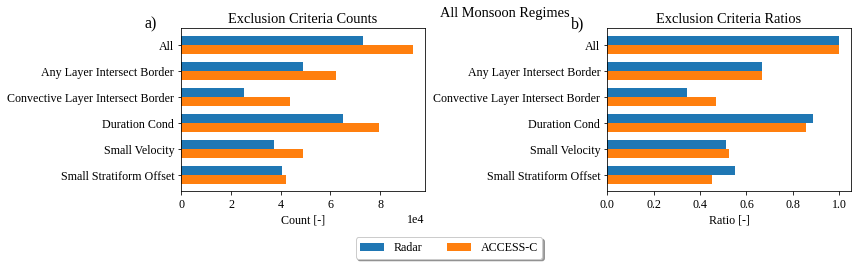

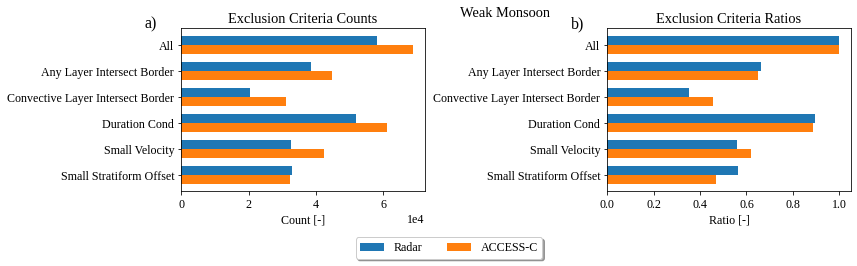

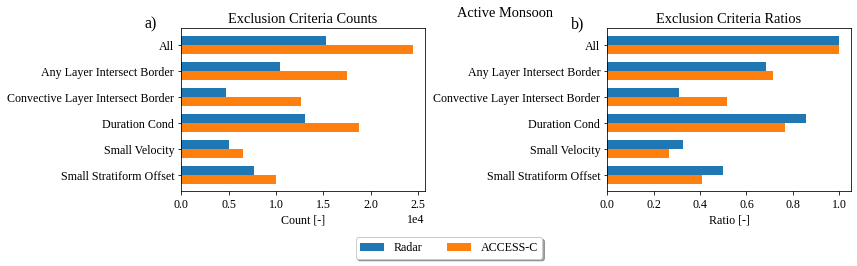

In [202]:
bs.compare_exclusions(all_excl_radar, all_excl_ACCESS, title='All Monsoon Regimes')
plt.savefig(
    fig_dir + 'excl_all_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')
bs.compare_exclusions(weak_excl_radar, weak_excl_ACCESS, title='Weak Monsoon')
plt.savefig(
    fig_dir + 'excl_weak_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')
bs.compare_exclusions(active_excl_radar, active_excl_ACCESS, title='Active Monsoon')
plt.savefig(
    fig_dir + 'excl_active_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

In [63]:
all_obs_radar = bs.get_boring_radar_stats(
    save_dir, ['simple_duration_cond'], None, radars=radars)
QC_obs_radar = bs.get_boring_radar_stats(
    save_dir, None, None, radars=radars)

all_obs_weak_radar = bs.get_boring_radar_stats(
    save_dir, ['simple_duration_cond'], 1, radars=radars)
QC_obs_weak_radar = bs.get_boring_radar_stats(
    save_dir, None, 1,
    radars=radars)

all_obs_active_radar = bs.get_boring_radar_stats(
    save_dir, ['simple_duration_cond'], 2, radars=radars)
QC_obs_active_radar = bs.get_boring_radar_stats(
    save_dir, None, 2, radars=radars)

Radar 42, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calc

No included observations.
Calculating system tracks.
No included observations.
Radar 77, year 2020.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Radar 77, year 2021.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.


In [64]:
all_obs_ACCESS = bs.get_boring_ACCESS_stats(
    save_dir, ['simple_duration_cond'], None, radars=radars)
QC_obs_ACCESS = bs.get_boring_ACCESS_stats(
    save_dir, None, None, radars=radars)

all_obs_weak_ACCESS = bs.get_boring_ACCESS_stats(
    save_dir, ['simple_duration_cond'], 1, radars=radars)
QC_obs_weak_ACCESS = bs.get_boring_ACCESS_stats(
    save_dir, None, 1, radars=radars)

all_obs_active_ACCESS = bs.get_boring_ACCESS_stats(
    save_dir, ['simple_duration_cond'], 2, radars=radars)
QC_obs_active_ACCESS = bs.get_boring_ACCESS_stats(
    save_dir, None, 2, radars=radars)

Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system 

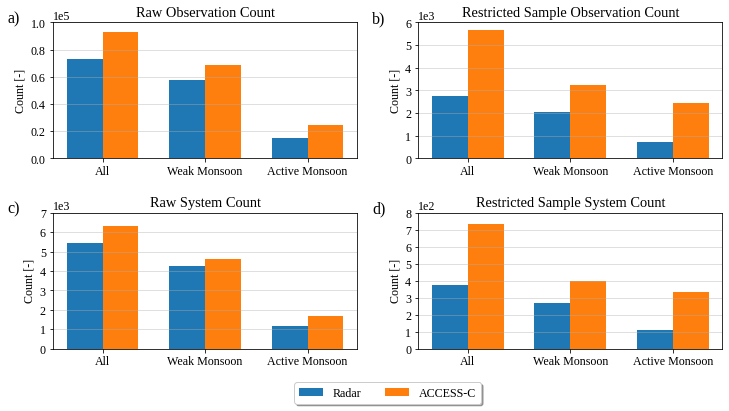

In [11]:
bs.plot_counts(
    all_obs_radar, all_obs_weak_radar, all_obs_active_radar,
    all_obs_ACCESS, all_obs_weak_ACCESS, all_obs_active_ACCESS,
    QC_obs_radar, QC_obs_weak_radar, QC_obs_active_radar,
    QC_obs_ACCESS, QC_obs_weak_ACCESS, QC_obs_active_ACCESS)
plt.savefig(
    fig_dir + 'totals_ACCESS_radar_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

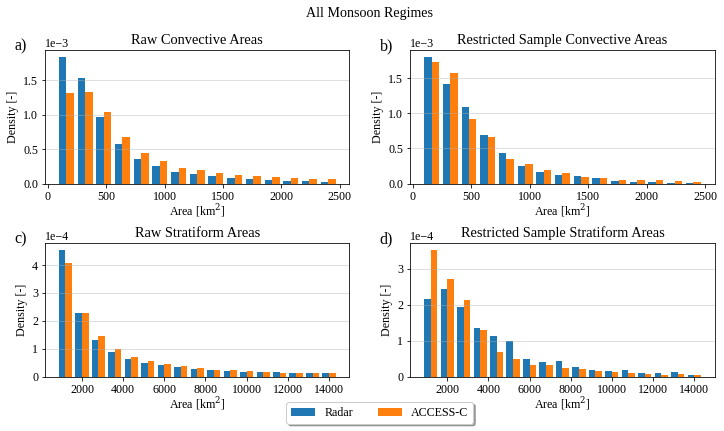

In [196]:
density = True

bs.compare_sizes(
    all_obs_radar, all_obs_ACCESS, 
    QC_obs_radar, QC_obs_ACCESS, density=density, 
    title='All Monsoon Regimes')
plt.savefig(
    fig_dir + 'sizes_ACCESS_radar_all_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

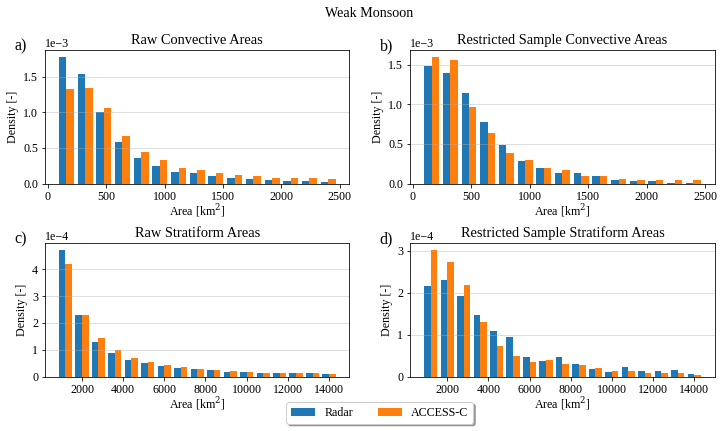

In [197]:
bs.compare_sizes(
    all_obs_weak_radar, all_obs_weak_ACCESS, 
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=density,
    title='Weak Monsoon')
plt.savefig(
    fig_dir + 'sizes_ACCESS_radar_weak_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

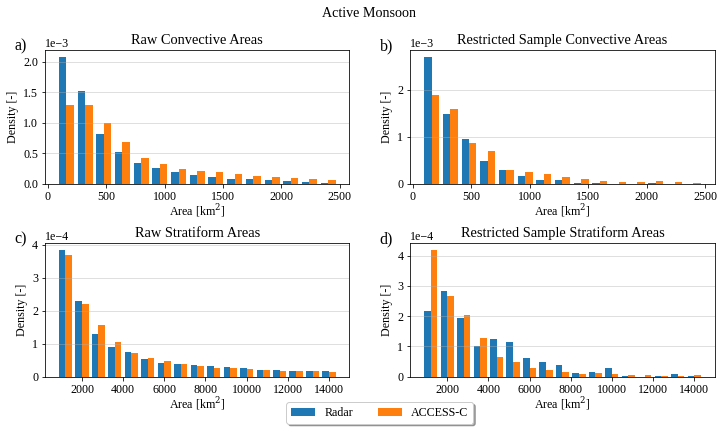

In [198]:
bs.compare_sizes(
    all_obs_active_radar, all_obs_active_ACCESS, 
    QC_obs_active_radar, QC_obs_active_ACCESS, density=density,
    title='Active Monsoon')
plt.savefig(
    fig_dir + 'sizes_ACCESS_radar_active_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

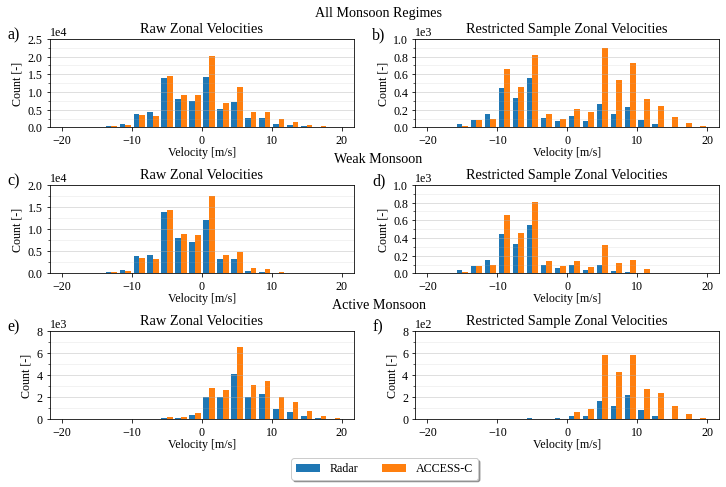

In [141]:
density=False

fig, axes = plt.subplots(3, 2, figsize=(12, 7))

bs.compare_velocities(
    all_obs_radar, all_obs_ACCESS,
    QC_obs_radar, QC_obs_ACCESS, density=density, 
    title='All Monsoon Regimes', labels=False,
    legend=False, fig=fig, ax=axes[0,:])

bs.compare_velocities(
    all_obs_weak_radar, all_obs_weak_ACCESS,
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=density, labels=False,
    title='Weak Monsoon', legend=False, fig=fig, ax=axes[1,:])

bs.compare_velocities(
    all_obs_active_radar, all_obs_active_ACCESS,
    QC_obs_active_radar, QC_obs_active_ACCESS, density=density, 
    labels=False, title='Active Monsoon', fig=fig, ax=axes[2,:])

plt.subplots_adjust(hspace=.65)

cl.make_subplot_labels(axes.flatten(), x_shift=-.14)

axes.flatten()[-2].legend(
    loc='lower center', bbox_to_anchor=(1.1, -0.75),
    ncol=2, fancybox=True, shadow=True)

maximums = [2.5e4, 10e2, 2e4, 10e2, 8e3, 8e2]
dy = [.5e4, 2e2, .5e4, 2e2, 2e3, 2e2]

for i in range(len(axes.flatten())):
    axes.flatten()[i].set_yticks(np.arange(0, maximums[i]+dy[i], dy[i]))
    axes.flatten()[i].set_yticks(
        np.arange(0, maximums[i]+dy[i]/2, dy[i]/2), minor=True)
    axes.flatten()[i].grid(which='minor', alpha=0.2, axis='y')
    axes.flatten()[i].grid(which='major', alpha=0.5, axis='y')
    
plt.savefig(
    fig_dir + '/zonal_ACCESS_radar_active_compare.png', 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

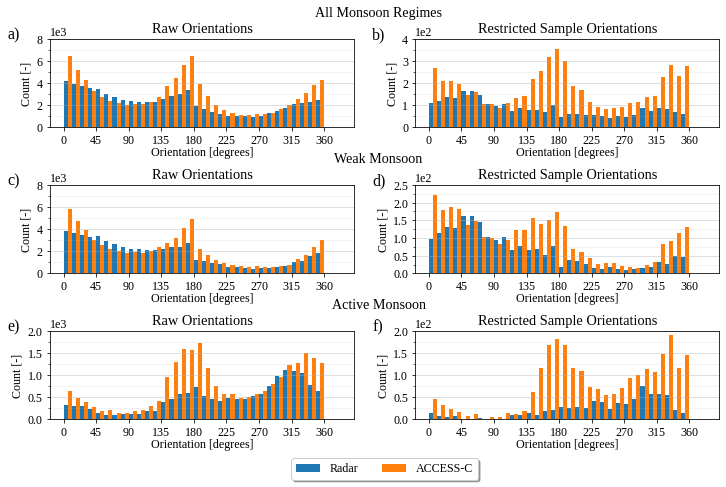

In [195]:
fig, axes = plt.subplots(3, 2, figsize=(12, 7))

bs.compare_orientation(
    all_obs_radar, all_obs_ACCESS,
    QC_obs_radar, QC_obs_ACCESS, density=density, 
    title='All Monsoon Regimes', fig=fig, ax=axes[0,:])

bs.compare_orientation(
    all_obs_weak_radar, all_obs_weak_ACCESS,
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=density, 
    title='Weak Monsoon', fig=fig, ax=axes[1,:])

bs.compare_orientation(
    all_obs_active_radar, all_obs_active_ACCESS,
    QC_obs_active_radar, QC_obs_active_ACCESS, density=density, 
    title='Active Monsoon', fig=fig, ax=axes[2,:])

axes.flatten()[-2].legend(
    loc='lower center', bbox_to_anchor=(1.1, -0.75),
    ncol=2, fancybox=True, shadow=True)

plt.subplots_adjust(hspace=.65)

cl.make_subplot_labels(axes.flatten(), x_shift=-.14)

maximums = [8e3, 4e2, 8e3, 2.5e2, 2e3, 2e2]
dy = [2e3, 1e2, 2e3, .5e2, .5e3, .5e2]

for i in range(len(axes.flatten())):
    axes.flatten()[i].set_yticks(np.arange(0, maximums[i]+dy[i], dy[i]))
    axes.flatten()[i].set_yticks(
        np.arange(0, maximums[i]+dy[i]/2, dy[i]/2), minor=True)
    axes.flatten()[i].grid(which='minor', alpha=0.2, axis='y')
    axes.flatten()[i].grid(which='major', alpha=0.5, axis='y')

plt.savefig(
    fig_dir + '/orientation_ACCESS_radar_active_compare.png', 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

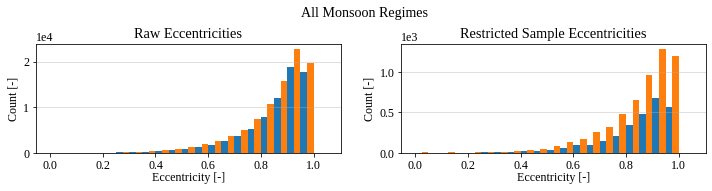

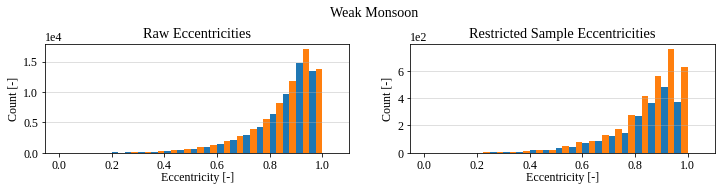

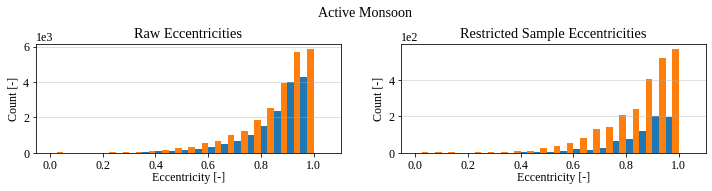

In [168]:
bs.compare_eccentricity(
    all_obs_radar, all_obs_ACCESS,
    QC_obs_radar, QC_obs_ACCESS, density=density, 
    title='All Monsoon Regimes')

plt.savefig(
    fig_dir + 'shape_ACCESS_radar_all_{}.png'.format(suff), 
    dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

bs.compare_eccentricity(
    all_obs_weak_radar, all_obs_weak_ACCESS,
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=density, 
    title='Weak Monsoon')

plt.savefig(
    fig_dir + 'shape_ACCESS_radar_weak_{}.png'.format(suff), 
    dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

bs.compare_eccentricity(
    all_obs_active_radar, all_obs_active_ACCESS,
    QC_obs_active_radar, QC_obs_active_ACCESS, density=density, 
    title='Active Monsoon')

plt.savefig(
    fig_dir + 'shape_ACCESS_radar_active_{}.png'.format(suff), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

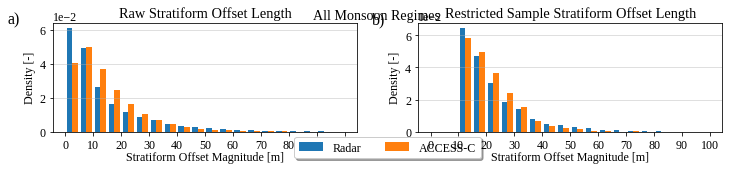

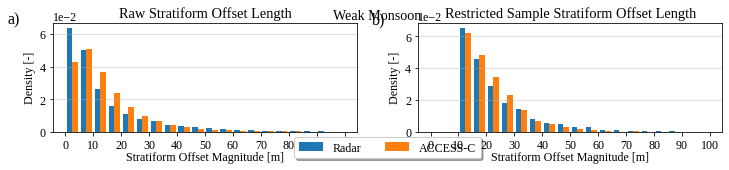

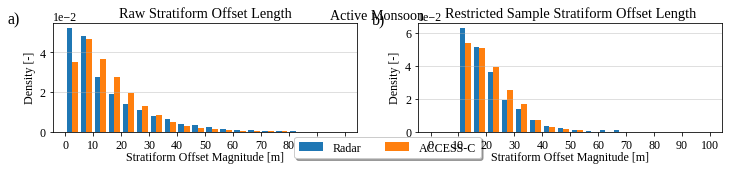

In [199]:
density = True

bs.compare_offset(
    all_obs_radar, all_obs_ACCESS,
    QC_obs_radar, QC_obs_ACCESS, density=density, 
    title='All Monsoon Regimes')

plt.savefig(
    fig_dir + 'offset_ACCESS_radar_all_{}.png'.format(suff), dpi=200, 
    facecolor='w', edgecolor='white', bbox_inches='tight')

bs.compare_offset(
    all_obs_weak_radar, all_obs_weak_ACCESS,
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=density, 
    title='Weak Monsoon')

plt.savefig(
    fig_dir + 'offset_ACCESS_radar_weak_{}.png'.format(suff), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

bs.compare_offset(
    all_obs_active_radar, all_obs_active_ACCESS,
    QC_obs_active_radar, QC_obs_active_ACCESS, density=density, 
    title='Active Monsoon')

plt.savefig(
    fig_dir + 'offset_ACCESS_radar_active_{}.png'.format(suff), dpi=200, 
    facecolor='w', edgecolor='white', bbox_inches='tight')

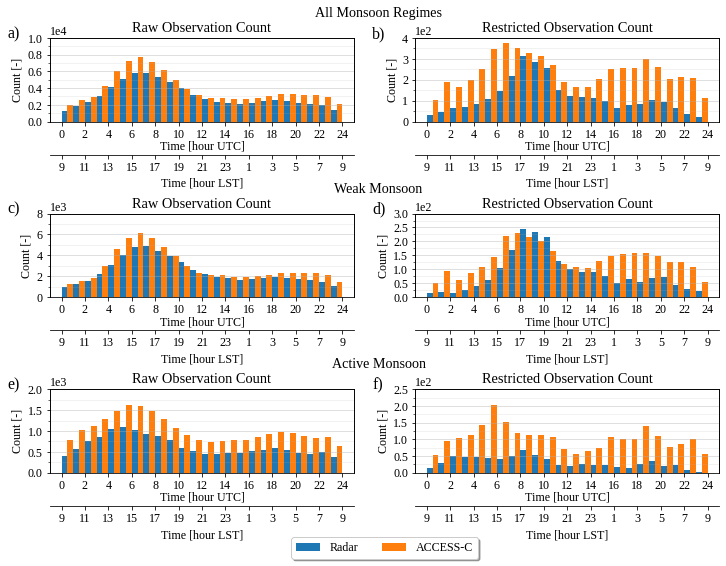

In [89]:
density=False

fig, axes = plt.subplots(3, 2, figsize=(12, 8))

bs.compare_time(
    all_obs_radar, all_obs_ACCESS,
    QC_obs_radar, QC_obs_ACCESS, density=density, 
    title='All Monsoon Regimes', fig=fig, ax=axes[0,:])

# plt.savefig(
#     fig_dir + 'time_ACCESS_radar_all_{}.png'.format(suff), dpi=200, 
#     facecolor='w', edgecolor='white', bbox_inches='tight')

bs.compare_time(
    all_obs_weak_radar, all_obs_weak_ACCESS,
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=density, 
    title='Weak Monsoon', fig=fig, ax=axes[1,:])

# plt.savefig(
#     fig_dir + 'time_ACCESS_radar_weak_{}.png'.format(suff), 
#     dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

bs.compare_time(
    all_obs_active_radar, all_obs_active_ACCESS,
    QC_obs_active_radar, QC_obs_active_ACCESS, density=density, 
    title='Active Monsoon', fig=fig, ax=axes[2,:])

axes.flatten()[-2].legend(
    loc='lower center', bbox_to_anchor=(1.1, -1.10),
    ncol=2, fancybox=True, shadow=True)

plt.subplots_adjust(hspace=1.1)

cl.make_subplot_labels(axes.flatten(), x_shift=-.14)

maximums = [10e3, 4e2, 8e3, 3e2, 2e3, 2.5e2]
dy = [2e3, 1e2, 2e3, .5e2, .5e3, .5e2]

for i in range(len(axes.flatten())):
    axes.flatten()[i].set_yticks(np.arange(0, maximums[i]+dy[i], dy[i]))
    axes.flatten()[i].set_yticks(
        np.arange(0, maximums[i]+dy[i]/2, dy[i]/2), minor=True)
    axes.flatten()[i].grid(which='minor', alpha=0.2, axis='y')
    axes.flatten()[i].grid(which='major', alpha=0.5, axis='y')

plt.savefig(
    fig_dir + '/time_ACCESS_radar_active_compare.png', dpi=200, 
    facecolor='w', edgecolor='white', bbox_inches='tight')

In [60]:
(np.arange(0,25,1)+9) % 24

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9])

(array([[0.        , 0.        , 0.        , 0.01401617, 0.01105121,
         0.00916442, 0.00889488, 0.0083558 , 0.00619946, 0.00431267,
         0.00512129, 0.00404313, 0.00269542, 0.00458221, 0.00431267,
         0.00161725, 0.00188679, 0.00080863, 0.00188679, 0.00107817,
         0.00404313, 0.00026954, 0.00053908, 0.00134771, 0.00134771,
         0.00053908, 0.00107817, 0.        , 0.00080863],
        [0.        , 0.        , 0.        , 0.01685083, 0.01325967,
         0.01187845, 0.00966851, 0.00662983, 0.00441989, 0.00593923,
         0.0058011 , 0.00400552, 0.00262431, 0.00276243, 0.00248619,
         0.00179558, 0.00082873, 0.00207182, 0.00220994, 0.00096685,
         0.00138122, 0.00124309, 0.00013812, 0.00069061, 0.00069061,
         0.00055249, 0.00027624, 0.00013812, 0.00069061]]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290]),
 <a list of 2 Ba

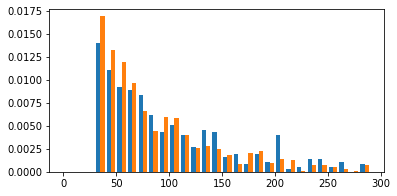

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))

ax.hist([QC_obs_radar[-1], QC_obs_ACCESS[-1]], bins=np.arange(0,300,10), density=True)

(array([ 0.,  0.,  0., 58., 49., 40., 32., 16., 17., 23., 19., 15., 10.,
         6.,  7.,  5.,  4.,  6.,  3.,  2.,  5.,  4.,  0.,  3.,  1.,  1.,
         1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  2.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
        390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510,
        520, 530, 540, 550, 560, 570, 580, 590]),
 <BarContainer object of 59 artists>)

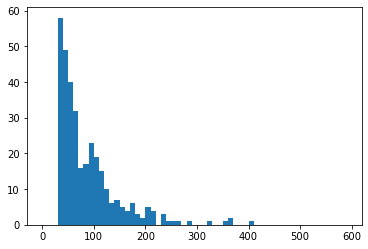

In [934]:
all_obs_ACCESS_42 = bs.get_boring_ACCESS_stats(
    save_dir, ['simple_duration_cond'], None, radars=[42])
QC_obs_ACCESS_42 = bs.get_boring_ACCESS_stats(
    save_dir, None, None, radars=[42])

all_obs_ACCESS_63 = bs.get_boring_ACCESS_stats(
    save_dir, ['simple_duration_cond'], None, radars=[63])
QC_obs_ACCESS_63 = bs.get_boring_ACCESS_stats(
    save_dir, None, None, radars=[63])

all_obs_ACCESS_77 = bs.get_boring_ACCESS_stats(
    save_dir, ['simple_duration_cond'], None, radars=[77])
QC_obs_ACCESS_77 = bs.get_boring_ACCESS_stats(
    save_dir, None, None, radars=[77])

all_obs_radar_42 = bs.get_boring_radar_stats(
    save_dir, ['simple_duration_cond'], None, radars=[42])
QC_obs_radar_42 = bs.get_boring_radar_stats(
    save_dir, None, None, radars=[42])

all_obs_radar_63 = bs.get_boring_radar_stats(
    save_dir, ['simple_duration_cond'], None, radars=[63])
QC_obs_radar_63 = bs.get_boring_radar_stats(
    save_dir, None, None, radars=[63])

all_obs_radar_77 = bs.get_boring_radar_stats(
    save_dir, ['simple_duration_cond'], None, radars=[77])
QC_obs_radar_77 = bs.get_boring_radar_stats(
    save_dir, None, None, radars=[77])

Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Rada

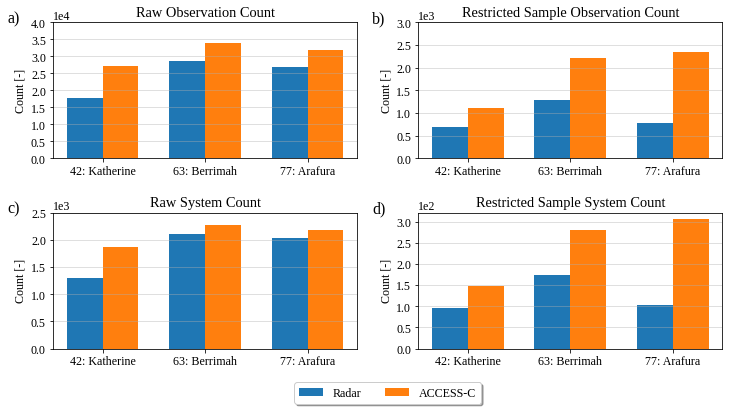

In [6]:
bs.plot_counts_regional(
    all_obs_radar_42, all_obs_radar_63, all_obs_radar_77,
    all_obs_ACCESS_42, all_obs_ACCESS_63, all_obs_ACCESS_77,
    QC_obs_radar_42, QC_obs_radar_63, QC_obs_radar_77,
    QC_obs_ACCESS_42, QC_obs_ACCESS_63, QC_obs_ACCESS_77)

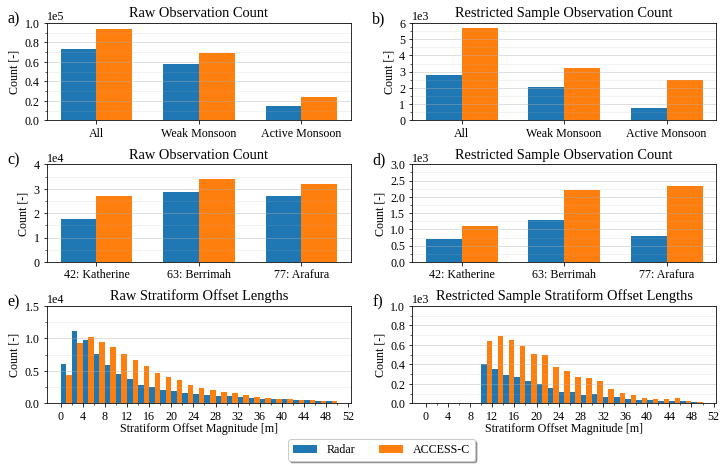

In [940]:
density = False

fig, axes = plt.subplots(3, 2, figsize=(12, 7))

bs.plot_counts_regional_seasonal(
    all_obs_radar, all_obs_weak_radar, all_obs_active_radar,
    all_obs_ACCESS, all_obs_weak_ACCESS, all_obs_active_ACCESS,
    QC_obs_radar, QC_obs_weak_radar, QC_obs_active_radar,
    QC_obs_ACCESS, QC_obs_weak_ACCESS, QC_obs_active_ACCESS,
    all_obs_radar_42, all_obs_radar_63, all_obs_radar_77,
    all_obs_ACCESS_42, all_obs_ACCESS_63, all_obs_ACCESS_77,
    QC_obs_radar_42, QC_obs_radar_63, QC_obs_radar_77,
    QC_obs_ACCESS_42, QC_obs_ACCESS_63, QC_obs_ACCESS_77,
    fig=fig, ax=axes[:2, :], legend=False, sp_labels=False)

bs.compare_offset(
    all_obs_radar, all_obs_ACCESS,
    QC_obs_radar, QC_obs_ACCESS, density=density, 
    fig=fig, ax=axes[2,:])

cl.make_subplot_labels(axes.flatten(), x_shift=-.13)

axes.flatten()[-2].legend(
    loc='lower center', bbox_to_anchor=(1.1, -0.65),
    ncol=2, fancybox=True, shadow=True)

plt.savefig(
    fig_dir + '/regional_seasonal_counts_offset.png'.format(suff), dpi=200, 
    facecolor='w', edgecolor='white', bbox_inches='tight')

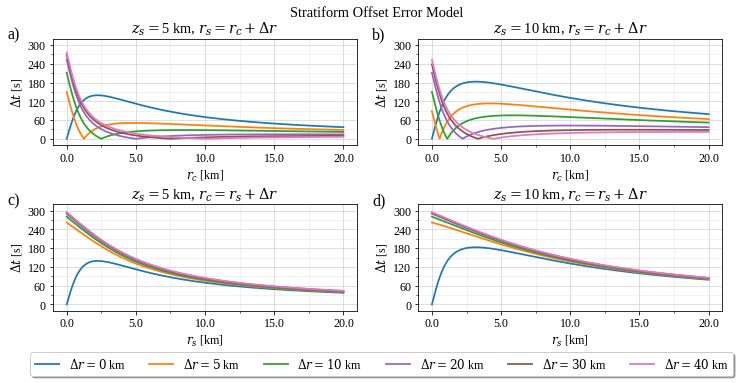

In [662]:
fig, ax = plt.subplots(2, 2, figsize=(12, 5))

bs.gen_error_model_plot(z_s=5000, fig=fig, ax=ax.flatten()[0])
bs.gen_error_model_plot(z_s=10000, fig=fig, ax=ax.flatten()[1])
bs.gen_error_model_plot(z_s=5000, fig=fig, ax=ax.flatten()[2], closest='stratiform')
bs.gen_error_model_plot(z_s=10000, fig=fig, ax=ax.flatten()[3], closest='stratiform')

# lines, labels = ax[0].get_legend_handles_labels()
# lines = [lines[i] for i in [0, 3, 1, 4, 2]]
# labels = [labels[i] for i in [0, 3, 1, 4, 2]]

ax.flatten()[2].legend(
    loc='lower center',
    bbox_to_anchor=(1.08, -.67),
    ncol=6, fancybox=True, shadow=True)

plt.subplots_adjust(hspace=.56)

plt.suptitle('Stratiform Offset Error Model', y=.97)

cl.make_subplot_labels(ax.flatten(), x_shift=-.15)

plt.savefig(
    fig_dir + '/error_model.png',
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

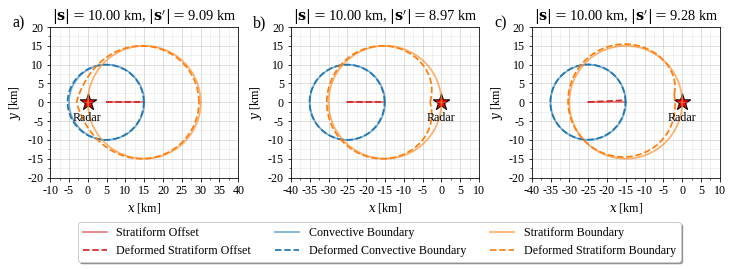

In [946]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# row 1
bs.plot_deformation(
    fig=fig, ax=ax[0], u=-10, v=0, strat_centroid_x=15e3, 
    conv_centroid_x=5e3, 
    conv_radius=10e3, strat_radius=15e3, tau=300, 
    extent=[-10e3, 40e3, -20e3, 20e3], dx=5e3)

bs.plot_deformation(
    fig=fig, ax=ax[1], u=-10, v=0, strat_centroid_x=-15e3, 
    conv_centroid_x=-25e3, conv_radius=10e3, strat_radius=15e3, 
    tau=300, extent=[-40e3, 10e3, -20e3, 20e3], dx=5e3)

bs.plot_deformation(
    fig=fig, ax=ax[2], u=-np.sqrt(1/2)*10, v=np.sqrt(1/2)*10, 
    strat_centroid_x=-15e3, conv_centroid_x=-25e3, conv_radius=10e3, 
    strat_radius=15e3, tau=300, extent=[-40e3, 10e3, -20e3, 20e3], 
    dx=5e3)

for i in range(len(ax.flatten())):
    ax.flatten()[i].set_aspect('equal')

ax[0].legend(
    loc='lower center',
    bbox_to_anchor=(1.75, -.6),
    ncol=3, fancybox=True, shadow=True)

cl.make_subplot_labels(ax.flatten(), x_shift=-.2)
plt.subplots_adjust(wspace=.28)

plt.savefig(
    fig_dir + '/deformation.png',
    dpi=200, facecolor='w', edgecolor='white', 
    bbox_inches='tight')

In [947]:
x_range = np.arange(-60e3, 61e3, 1e3)
conv_radius = 10e3
strat_radius = 15e3

so_list = [10e3, 10e3, 10e3, 40e3, 10e3, 10e3]
u_list = [-10, -10, -np.sqrt(1/2)*10, -10, -10, -10]
v_list = [0, 0, np.sqrt(1/2)*10, 0, 0, 0]
conv_centroid_y = [0, 20e3, 0, 0, 0, 0]
strat_centroid_y = [0, 20e3, 0, 0, 0, 0]
conv_radius = [10e3, 10e3, 10e3, 10e3, 20e3, 10e3]
strat_radius = [15e3, 15e3, 15e3, 15e3, 15e3, 30e3]

labels = [
    r'Baseline', r'$y$ Displacement', r'Non-Parallel',
    r'$|\mathrm{\mathbf{s}}|=$ 40 km', r'Larger Convective Area', 
    r'Larger Stratiform Area']

In [948]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = [colors[i] for i in [0, 1, 2, 4, 5, 6]]

In [949]:
offsets = [np.zeros(len(x_range)) for i in range(len(so_list))]

for k in range(len(so_list)):
    for i in range(len(x_range)):
        offset = bs.plot_deformation(
            u=u_list[k], v=v_list[k], 
            strat_centroid_x=x_range[i], 
            conv_centroid_x=(x_range[i]+so_list[k]),
            conv_radius=conv_radius[k], strat_radius=strat_radius[k],
            conv_centroid_y=conv_centroid_y[k],
            strat_centroid_y=strat_centroid_y[k],
            tau=300, plot=False)
        offsets[k][i] = offset
        plt.close('all')

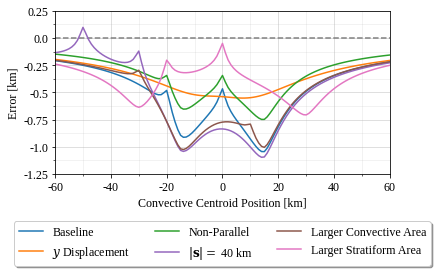

In [951]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# for so in list(set(so_list))[:-1]:
#     ax.plot(
#         x_range, so*np.ones_like(x_range),  '--', color='grey')
ax.plot(
    x_range, np.zeros_like(x_range),  '--', color='grey')

extent = [-60e3, 60e3, -1.25e3, .25e3]
dx = 20e3
dy = .25e3

for k in range(len(so_list)):

    ax.plot(
        x_range, so_list[k]-offsets[k], color=colors[k], label=labels[k])

ax.set_xlim([extent[0], extent[1]])
ax.set_ylim([extent[2], extent[3]])
ax.set_xticks(np.arange(extent[0], extent[1]+dx, dx))
ax.set_xticks(
    np.arange(extent[0], extent[1]+dx/2, dx/2), minor=True)
ax.set_xticklabels(
    (np.arange(extent[0], extent[1]+dx, dx)/1e3).astype(int))
ax.set_yticks(np.arange(extent[2], extent[3]+dy, dy))
ax.set_yticks(
    np.arange(extent[2], extent[3]+dy/2, dy/2), minor=True)
ax.set_yticklabels(
    (np.arange(extent[2], extent[3]+dy, dy)/1e3).round(2))

ax.grid(which='minor', alpha=0.2, axis='both')
ax.grid(which='major', alpha=0.5, axis='both')
ax.set_xlabel(r'Convective Centroid Position [km]')
ax.set_ylabel(r"Error [km]")
    
ax.legend(
    loc='lower center',
    bbox_to_anchor=(.5, -.6),
    ncol=3, fancybox=True, shadow=True)

plt.savefig(
    fig_dir + '/so_error.png',
    dpi=200, facecolor='w', edgecolor='white', 
    bbox_inches='tight')

In [ ]:
ACCESS_dicts = td.shear_versus_orientation_ACCESS()

In [53]:
radar_dicts = td.shear_versus_orientation_radar()

Getting data for radar 42, year 2020, month 10.
Getting data for radar 42, year 2020, month 11.
Getting data for radar 42, year 2020, month 12.
Getting data for radar 42, year 2021, month 1.
Getting data for radar 42, year 2021, month 2.
Getting data for radar 42, year 2021, month 3.
Getting data for radar 42, year 2021, month 4.
No systems.
Getting data for radar 63, year 2020, month 10.
Getting data for radar 63, year 2020, month 11.
Getting data for radar 63, year 2020, month 12.
Getting data for radar 63, year 2021, month 1.
Getting data for radar 63, year 2021, month 2.
Getting data for radar 63, year 2021, month 3.
Getting data for radar 63, year 2021, month 4.
Getting data for radar 77, year 2020, month 10.
Getting data for radar 77, year 2020, month 11.
Getting data for radar 77, year 2020, month 12.
Getting data for radar 77, year 2021, month 1.
Getting data for radar 77, year 2021, month 2.
Getting data for radar 77, year 2021, month 3.
Getting data for radar 77, year 2021, m

[1.0, 1.0, 1.0, 1.0]

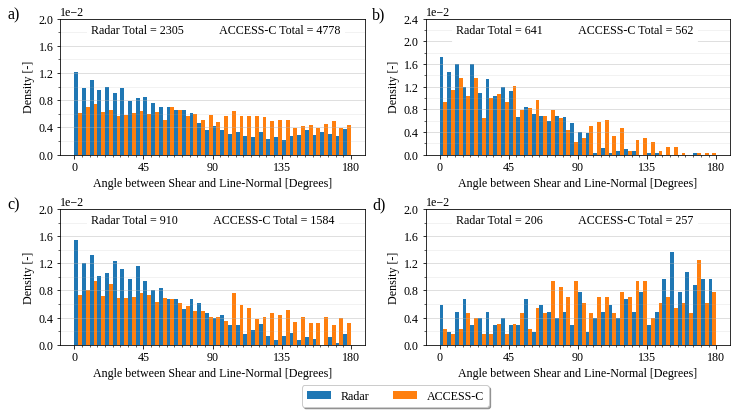

In [55]:
td.shear_angle_versus_orientation_hist_compare(radar_dicts, ACCESS_dicts)

[1.0, 1.0, 1.0, 1.0]

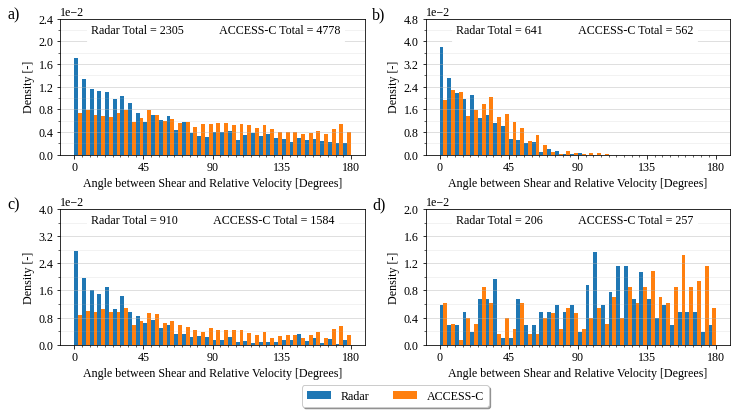

In [57]:
td.shear_angle_versus_propagation_hist_compare(radar_dicts, ACCESS_dicts)